# Hoàng Phương Linh - 18020758

In [ ]:
import pandas as pd
import numpy as np
import cv2
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.impute import SimpleImputer
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeRegressor
import sklearn.ensemble as ens
import xgboost as xgb
import json
import os
import re
from sklearn import preprocessing
import torch
import torch.nn as nn
import torchvision.models as models
from torchvision import transforms as T
import lightgbm as lgb
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix

# Load dữ liệu train, test

In [ ]:
# Chuyển sang True nếu có dùng dữ liệu đó để train và test
TRAIN_IMAGE_DENSENET121_SVD = False
TRAIN_IMAGE_DENSENET121_NMF = False
TRAIN_IMAGE_VGG19_NMF = False
TRAIN_TEXT = False

In [ ]:
# load file dữ liệu train đã được tiền xử lý
train = pd.read_csv('../input/train4/train_petfinder4.csv')

# Gán 1 dataframe làm nhãn
train_label = pd.DataFrame()
train_label['AdoptionSpeed'] = train['AdoptionSpeed']

# Loại bỏ trường label AdoptionSpeed và các truờng text, ID ra khỏi tập train
train = train.drop(['AdoptionSpeed','DescriptionImage','SentimentEntity','Name','Description','RescuerID','PetID'], axis=1)

# Loại bỏ trường bên duới để nâng điểm cho model LightGBM (tìm được qua Feature_Importance)
drop_for_lgb = ['HaveVideo','HavePhoto', 'PhotoAmt_Normalize','NumberColor', 'onePet']
# Loại bỏ trường bên duới để nâng điểm cho model GradientBoosting (tìm được qua Feature_Importance)
drop_for_gb = ['HavePhoto','SentimentThreshold']

# Mã hoá trường State từ 0->13
le = preprocessing.LabelEncoder()
le.fit(train['State'])
train['State'] = le.transform(train['State'])

# Nếu không train ảnh VGG19_NMF thì bỏ ra khoải tập train
if not TRAIN_IMAGE_VGG19_NMF:
    train = train.drop([ 
        'ImageNMF0', 'ImageNMF1', 'ImageNMF2', 'ImageNMF3', 'ImageNMF4',
       'ImageNMF5', 'ImageNMF6', 'ImageNMF7', 'ImageNMF8', 'ImageNMF9',
       'ImageNMF10', 'ImageNMF11', 'ImageNMF12', 'ImageNMF13', 'ImageNMF14',
       'ImageNMF15', 'ImageNMF16', 'ImageNMF17', 'ImageNMF18', 'ImageNMF19',
       'ImageNMF20', 'ImageNMF21', 'ImageNMF22', 'ImageNMF23', 'ImageNMF24',
       'ImageNMF25', 'ImageNMF26', 'ImageNMF27', 'ImageNMF28', 'ImageNMF29','ImageNMF30', 'ImageNMF31'], axis=1)
    
# Nếu không train ảnh DENSENET121_NMF thì bỏ ra khoải tập train
if not TRAIN_IMAGE_DENSENET121_NMF:
    train = train.drop([ 'DenseNet121imageNMF0',
       'DenseNet121imageNMF1', 'DenseNet121imageNMF2', 'DenseNet121imageNMF3',
       'DenseNet121imageNMF4', 'DenseNet121imageNMF5', 'DenseNet121imageNMF6',
       'DenseNet121imageNMF7', 'DenseNet121imageNMF8', 'DenseNet121imageNMF9',
       'DenseNet121imageNMF10', 'DenseNet121imageNMF11',
       'DenseNet121imageNMF12', 'DenseNet121imageNMF13',
       'DenseNet121imageNMF14', 'DenseNet121imageNMF15',
       'DenseNet121imageNMF16', 'DenseNet121imageNMF17',
       'DenseNet121imageNMF18', 'DenseNet121imageNMF19',
       'DenseNet121imageNMF20', 'DenseNet121imageNMF21',
       'DenseNet121imageNMF22', 'DenseNet121imageNMF23',
       'DenseNet121imageNMF24', 'DenseNet121imageNMF25',
       'DenseNet121imageNMF26', 'DenseNet121imageNMF27',
       'DenseNet121imageNMF28', 'DenseNet121imageNMF29',
       'DenseNet121imageNMF30', 'DenseNet121imageNMF31'], axis=1)

# Nếu không train ảnh DENSENET121_SVD thì bỏ ra khoải tập train
if not TRAIN_IMAGE_DENSENET121_SVD:
    train = train.drop(['DenseNet121imageSVD0',
       'DenseNet121imageSVD1', 'DenseNet121imageSVD2', 'DenseNet121imageSVD3',
       'DenseNet121imageSVD4', 'DenseNet121imageSVD5', 'DenseNet121imageSVD6',
       'DenseNet121imageSVD7', 'DenseNet121imageSVD8', 'DenseNet121imageSVD9',
       'DenseNet121imageSVD10', 'DenseNet121imageSVD11',
       'DenseNet121imageSVD12', 'DenseNet121imageSVD13',
       'DenseNet121imageSVD14', 'DenseNet121imageSVD15',
       'DenseNet121imageSVD16', 'DenseNet121imageSVD17',
       'DenseNet121imageSVD18', 'DenseNet121imageSVD19',
       'DenseNet121imageSVD20', 'DenseNet121imageSVD21',
       'DenseNet121imageSVD22', 'DenseNet121imageSVD23',
       'DenseNet121imageSVD24', 'DenseNet121imageSVD25',
       'DenseNet121imageSVD26', 'DenseNet121imageSVD27',
       'DenseNet121imageSVD28', 'DenseNet121imageSVD29',
       'DenseNet121imageSVD30', 'DenseNet121imageSVD31'], axis=1)

# Nếu không train text thì bỏ ra khoải tập train
if not TRAIN_TEXT:
    train = train.drop(['DescriptionSVD0',
       'DescriptionSVD1', 'DescriptionSVD2', 'DescriptionSVD3',
       'DescriptionSVD4', 'DescriptionSVD5', 'DescriptionSVD6',
       'DescriptionSVD7', 'SentimentEntitynSVD0', 'SentimentEntitynSVD1',
       'SentimentEntitynSVD2', 'SentimentEntitynSVD3', 'SentimentEntitynSVD4',
       'SentimentEntitynSVD5', 'SentimentEntitynSVD6', 'SentimentEntitynSVD7',
       'DescriptionImageSVD0', 'DescriptionImageSVD1', 'DescriptionImageSVD2',
       'DescriptionImageSVD3', 'DescriptionImageSVD4', 'DescriptionImageSVD5',
       'DescriptionImageSVD6', 'DescriptionImageSVD7'], axis=1)

# Chia tập train thành 2 phần train và test
X_train, X_test, y_train, y_test = train_test_split(train,train_label['AdoptionSpeed'], test_size=0.33, random_state=42)

# Gán vào 2 biến X, y để lát train theo KFold
X = train.values
y = train_label['AdoptionSpeed']

In [ ]:
# load file dữ liệu test để nộp đã được tiền xử lý
test_data = pd.read_csv('../input/test4444/test_petfinder4.csv')
test = test_data.copy()

# Loại bỏ trường label AdoptionSpeed và các truờng text, ID ra khỏi tập test để nộp
test = test.drop(['DescriptionImage','SentimentEntity','Name','Description','RescuerID','PetID'], axis=1)

# Loại bỏ trường bên duới để nâng điểm cho model LightGBM (tìm được qua Feature_Importance)
drop_for_lgb = ['HaveVideo','HavePhoto', 'PhotoAmt_Normalize','NumberColor', 'onePet']
# Loại bỏ trường bên duới để nâng điểm cho model GradientBoosting (tìm được qua Feature_Importance)
drop_for_gb = ['HavePhoto','SentimentThreshold']

# Mã hoá trường State từ 0->13
le = preprocessing.LabelEncoder()
le.fit(test['State'])
test['State'] = le.transform(test['State'])

# Nếu không train ảnh VGG19_NMF thì bỏ ra khoải tập test để nộp
if not TRAIN_IMAGE_VGG19_NMF:
    test = test.drop([ 
        'ImageNMF0', 'ImageNMF1', 'ImageNMF2', 'ImageNMF3', 'ImageNMF4',
       'ImageNMF5', 'ImageNMF6', 'ImageNMF7', 'ImageNMF8', 'ImageNMF9',
       'ImageNMF10', 'ImageNMF11', 'ImageNMF12', 'ImageNMF13', 'ImageNMF14',
       'ImageNMF15', 'ImageNMF16', 'ImageNMF17', 'ImageNMF18', 'ImageNMF19',
       'ImageNMF20', 'ImageNMF21', 'ImageNMF22', 'ImageNMF23', 'ImageNMF24',
       'ImageNMF25', 'ImageNMF26', 'ImageNMF27', 'ImageNMF28', 'ImageNMF29','ImageNMF30', 'ImageNMF31'], axis=1)

# Nếu không train ảnh DENSENET121_NMF thì bỏ ra khoải tập test để nộp
if not TRAIN_IMAGE_DENSENET121_NMF:
    test = test.drop([ 'DenseNet121imageNMF0',
       'DenseNet121imageNMF1', 'DenseNet121imageNMF2', 'DenseNet121imageNMF3',
       'DenseNet121imageNMF4', 'DenseNet121imageNMF5', 'DenseNet121imageNMF6',
       'DenseNet121imageNMF7', 'DenseNet121imageNMF8', 'DenseNet121imageNMF9',
       'DenseNet121imageNMF10', 'DenseNet121imageNMF11',
       'DenseNet121imageNMF12', 'DenseNet121imageNMF13',
       'DenseNet121imageNMF14', 'DenseNet121imageNMF15',
       'DenseNet121imageNMF16', 'DenseNet121imageNMF17',
       'DenseNet121imageNMF18', 'DenseNet121imageNMF19',
       'DenseNet121imageNMF20', 'DenseNet121imageNMF21',
       'DenseNet121imageNMF22', 'DenseNet121imageNMF23',
       'DenseNet121imageNMF24', 'DenseNet121imageNMF25',
       'DenseNet121imageNMF26', 'DenseNet121imageNMF27',
       'DenseNet121imageNMF28', 'DenseNet121imageNMF29',
       'DenseNet121imageNMF30', 'DenseNet121imageNMF31'], axis=1)

# Nếu không train ảnh DENSENET121_SVD thì bỏ ra khoải tập test để nộp
if not TRAIN_IMAGE_DENSENET121_SVD:
    test = test.drop(['DenseNet121imageSVD0',
       'DenseNet121imageSVD1', 'DenseNet121imageSVD2', 'DenseNet121imageSVD3',
       'DenseNet121imageSVD4', 'DenseNet121imageSVD5', 'DenseNet121imageSVD6',
       'DenseNet121imageSVD7', 'DenseNet121imageSVD8', 'DenseNet121imageSVD9',
       'DenseNet121imageSVD10', 'DenseNet121imageSVD11',
       'DenseNet121imageSVD12', 'DenseNet121imageSVD13',
       'DenseNet121imageSVD14', 'DenseNet121imageSVD15',
       'DenseNet121imageSVD16', 'DenseNet121imageSVD17',
       'DenseNet121imageSVD18', 'DenseNet121imageSVD19',
       'DenseNet121imageSVD20', 'DenseNet121imageSVD21',
       'DenseNet121imageSVD22', 'DenseNet121imageSVD23',
       'DenseNet121imageSVD24', 'DenseNet121imageSVD25',
       'DenseNet121imageSVD26', 'DenseNet121imageSVD27',
       'DenseNet121imageSVD28', 'DenseNet121imageSVD29',
       'DenseNet121imageSVD30', 'DenseNet121imageSVD31'], axis=1)
    
# Nếu không train text thì bỏ ra khoải tập test để nộp
if not TRAIN_TEXT:
    test = test.drop(['DescriptionSVD0',
       'DescriptionSVD1', 'DescriptionSVD2', 'DescriptionSVD3',
       'DescriptionSVD4', 'DescriptionSVD5', 'DescriptionSVD6',
       'DescriptionSVD7', 'SentimentEntitynSVD0', 'SentimentEntitynSVD1',
       'SentimentEntitynSVD2', 'SentimentEntitynSVD3', 'SentimentEntitynSVD4',
       'SentimentEntitynSVD5', 'SentimentEntitynSVD6', 'SentimentEntitynSVD7',
       'DescriptionImageSVD0', 'DescriptionImageSVD1', 'DescriptionImageSVD2',
       'DescriptionImageSVD3', 'DescriptionImageSVD4', 'DescriptionImageSVD5',
       'DescriptionImageSVD6', 'DescriptionImageSVD7'], axis=1)


# Random Forest

In [ ]:
def RandomForestClassifier_kfold(X,y,n_splits):
    # Áp dụng K_fold với n_splits
    kf = KFold(n_splits=n_splits)
    clf = RandomForestClassifier(max_depth=10,n_estimators = 300)
    cnt = 0
    # Train từng fold và in ra score từng fold ứng với train và test từng fold
    for train_index, val_index in kf.split(X):
        clf.fit(X[train_index], y[train_index])
        cnt += 1
        print('Fold '+ str(cnt), end=': train: ')
        print(clf.score(X[train_index], y[train_index]), end=' test: ')
        print(clf.score(X[val_index], y[val_index]))
    return clf

def RandomForestClassifier_(X_train, X_test, y_train, y_test):
    clf = RandomForestClassifier(max_depth=10,n_estimators = 300)
    # Train bình thưòng và in ra score ứng với train và test
    clf.fit(X_train.values, y_train)
    print(clf.score(X_train.values, y_train))
    print(clf.score(X_test.values, y_test))
    return clf

**Sử dụng thuật toán RandomForest**
- **Chỉnh tham số:**
    - max_depth: 10 (mặc định là None)
    - n_estimators: 300 cây (mặc định là 100)
- **Score Kaggle:** 0.29779
- **Score KFold:**
    - Fold 1: train: 0.656995164248791 test: 0.37712570856952315
    - Fold 2: train: 0.6532432883108221 test: 0.3777925975325108
    - Fold 3: train: 0.6599966649991662 test: 0.4081360453484495
    - Fold 4: train: 0.6678616090037516 test: 0.3975983989326217
    - Fold 5: train: 0.6726135889954148 test: 0.4336224149432955
- **Score train thường không áp dụng KFold:**
    - Train: 0.686411149825784
    - Test: 0.4308811641067098
- **Confusion_matrix train thường không áp dụng KFold:**
- 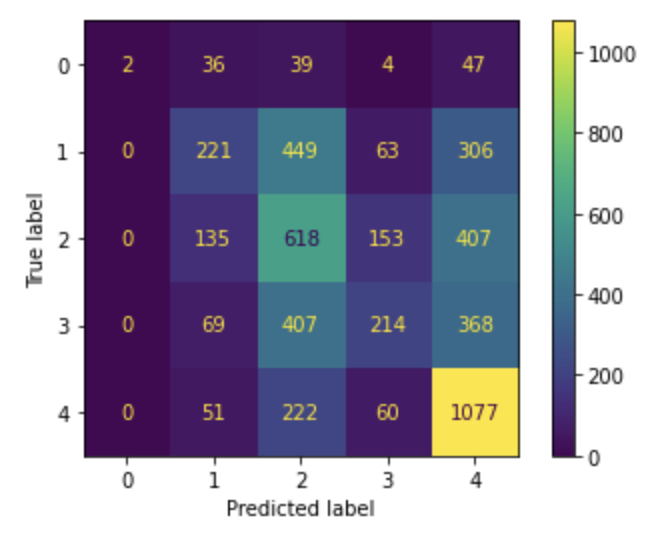

# LightGBM

In [ ]:
def LGBMClassifier_kfold(X,y,n_splits):
    # Áp dụng K_fold với n_splits
    kf = KFold(n_splits=n_splits)
    clf = lgb.LGBMClassifier(application='multiclass',learning_rate= 0.01,num_leaves=70,metric='multi_logloss',max_depth=10,
                             n_estimators = 300,min_split_gain= 0.02,min_child_samples= 150,min_child_weight= 0.02)
    cnt = 0
    # Train từng fold và in ra score từng fold ứng với train và test từng fold
    for train_index, val_index in kf.split(X):
        clf.fit(X[train_index], y[train_index])
        cnt += 1
        print('Fold '+ str(cnt), end=': train: ')
        print(clf.score(X[train_index], y[train_index]), end=' test: ')
        print(clf.score(X[val_index], y[val_index]))
    return clf

def LGBMClassifier_(X_train, X_test, y_train, y_test):
    clf = lgb.LGBMClassifier(application='multiclass',learning_rate= 0.01,num_leaves= 70,metric='multi_logloss',max_depth=10,
                             n_estimators = 300,min_split_gain= 0.02, min_child_samples= 150,min_child_weight= 0.02)
    # Train bình thưòng và in ra score ứng với train và test
    clf.fit(X_train.values, y_train)
    print(clf.score(X_train.values, y_train))
    print(clf.score(X_test.values, y_test))
    return clf

**Sử dụng thuật toán LightGBM** (gradient boosting dựa trên Decision Tree)
- **Chỉnh tham số:**
    - application: multiclass (chỉnh cho bài đa nhãn)
    - boosting: gdbt (mặc định)
    - learning_rate: 0.01
    - num_leaves: 70 (mặc định là 31) (<= 2^max_depth không thì sẽ overfitting)
    
    - metric: multi_logloss (chỉnh loại hàm loss cho bài đa nhãn)
    - max_depth: 10 (mặc định là -1)
    - n_estimators: 300 cây (mặc định là 100)
    - min_split_gain: 0.02 (mặc định là 0)
    - min_child_samples: 150 (mặc định là 20)
    - min_child_weight:  0.02 (mặc định là 1e-3)
- **Score Kaggle:** 0.32996 (sau khi tinh chỉnh tham số là 0.32906, còn cao nhất là 0.32996 khi loại bỏ các truờng ['HaveVideo','HavePhoto', 'PhotoAmt_Normalize','NumberColor', 'onePet'] có giá trị feature importance thấp nhất)
- **Score KFold:**
    - Fold 1: train: 0.5761213940303485 test: 0.3651217072357453
    - Fold 2: train: 0.5777888944472236 test: 0.3801267089029677
    - Fold 3: train: 0.5922127730531933 test: 0.3881293764588196
    - Fold 4: train: 0.5934139224676949 test: 0.38892595063375585
    - Fold 5: train: 0.5887453105460608 test: 0.43862575050033353
- **Score train thường không áp dụng KFold:**
    - Train: 0.5851667496266799
    - Test: 0.43047696038803557
- **Confusion_matrix train thường không áp dụng KFold:**
- 
 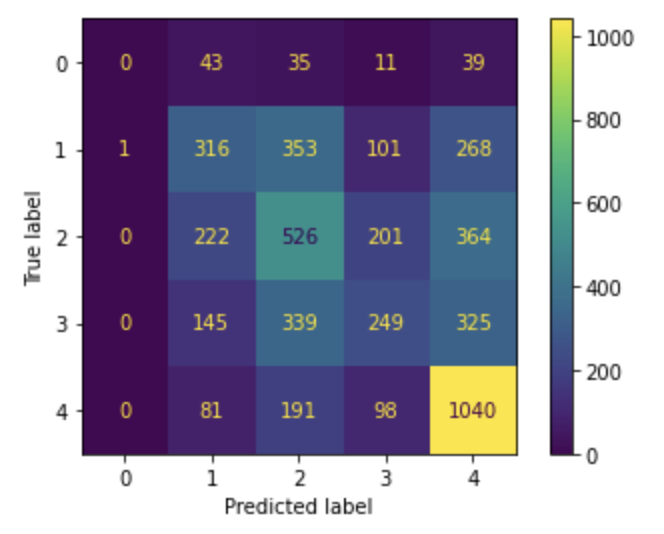   
 

# GradientBoosting

In [ ]:
def GradientBoostingClassifier_kfold(X,y,n_splits):
    # Áp dụng K_fold với n_splits
    kf = KFold(n_splits=n_splits)
    clf = GradientBoostingClassifier()
    cnt = 0
    # Train từng fold và in ra score từng fold ứng với train và test từng fold
    for train_index, val_index in kf.split(X):
        clf.fit(X[train_index], y[train_index])
        cnt += 1
        print('Fold '+ str(cnt), end=': train: ')
        print(clf.score(X[train_index], y[train_index]), end=' test: ')
        print(clf.score(X[val_index], y[val_index]))
    return clf

def GradientBoostingClassifier_(X_train, X_test, y_train, y_test):
    clf = GradientBoostingClassifier()
    # Train bình thưòng và in ra score ứng với train và test
    clf.fit(X_train.values, y_train)
    print(clf.score(X_train.values, y_train))
    print(clf.score(X_test.values, y_test))
    return clf

**Sử dụng thuật toán RandomForest**
- **Chỉnh tham số:** tham số mặc định là điểm cao nhất
- **Score Kaggle:** 0.33031 (sau khi tinh chỉnh tham số là 0.33025, còn cao nhất là 0.33031 khi loại bỏ các truờng ['HavePhoto','SentimentThreshold'] có giá trị feature importance thấp nhất)
- **Score KFold:**
    - Fold 1: train: 0.512589628147407 test: 0.35345115038346114
    - Fold 2: train: 0.5121727530431882 test: 0.3864621540513504
    - Fold 3: train: 0.5230115057528765 test: 0.3891297099033011
    - Fold 4: train: 0.5185493955814923 test: 0.38925950633755835
    - Fold 5: train: 0.5167986661108795 test: 0.4409606404269513
- **Score train thường không áp dụng KFold:**
    - Train: 0.5253359880537581
    - Test: 0.431285367825384
- **Confusion_matrix train thường không áp dụng KFold:**
- 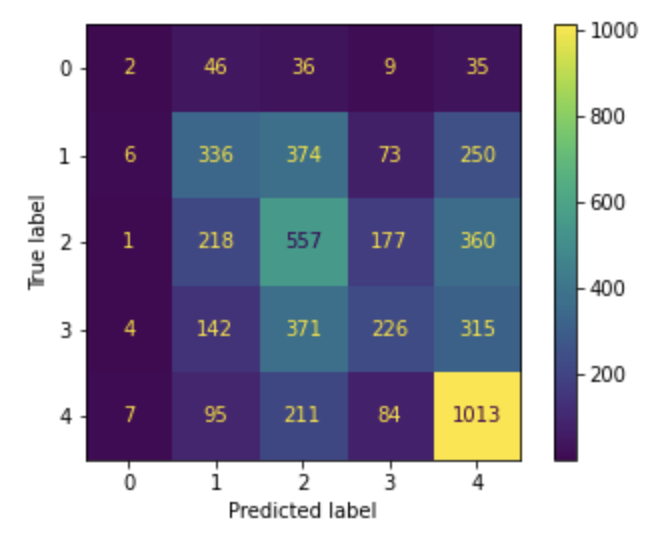

# Feature Importance

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

def plotImp(model, X , fig_size = (40, 20)):
    num = len(X.columns)
    # Lấy giá trị feature_importance của từng feature qua model
    feature_imp = pd.DataFrame({'Value':model.feature_importances_,'Feature':X.columns})
    # Vẽ biểu đồ cột
    plt.figure(figsize=fig_size)
    sns.set(font_scale = 2)
    sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", 
                                                        ascending=False)[0:num])
    plt.title('Features (avg over folds)')
    plt.tight_layout()
    plt.show()

**feature_importance của RandomForestClassifier_kfold**

In [ ]:
# feature_importance của RandomForestClassifier_kfold
clf=RandomForestClassifier_kfold(X,y,5)
plotImp(clf, train)

Các feature qua model RandomForestClassifier_kfold đều có giá trị quan trọng dù ít hay nhiều, bỏ đi đều gây giảm score

**feature_importance của LGBMClassifier_kfold**

In [ ]:
# feature_importance của LGBMClassifier_kfold
clf=LGBMClassifier_kfold(X,y,5)
plotImp(clf, train)

Sau khi loại bỏ các giá trị ít quan trọng nhất ['HaveVideo','HavePhoto', 'PhotoAmt_Normalize','NumberColor', 'onePet'], score Kaggle tăng từ 0.32906 lên 0.32996

**feature_importance của GradientBoostingClassifier_kfold**

In [ ]:
# feature_importance của GradientBoostingClassifier_kfold
clf=GradientBoostingClassifier_kfold(X,y,5)
plotImp(clf, train)

Sau khi loại bỏ các giá trị ít quan trọng nhất ['HavePhoto','SentimentThreshold'], score Kaggle tăng từ 0.33025 lên 0.33031

# Train

In [ ]:
# Sử dụng hàm cần train ở đây
clf = GradientBoostingClassifier_kfold(X,y,5)

# Nộp bài

In [ ]:
output = clf.predict(test.values)
sub = pd.DataFrame()
sub['PetID'] = test_data['PetID']
sub['AdoptionSpeed'] = output
sub.to_csv('submission.csv', index=False)